# <font color='#FF0066'> USO de DICOM: Formación post curso (2023) </font>

En esta notebook se muestra un ejemplo de manejo de imágenes DICOM en python. En primer lugar se muestran conceptos básicos de manejo de imágenes DICOM utilizando para ello un dataset sencillo de imágenes de TAC.</br> 
A continuación se mostrará como manejar imágenes en 3D a partir de otro dataset de imágenes de MRI.
* [Introducción al uso de DICOM](#intro_dicom)
    * [Dataset](#dataset)
    * [Código](#codigo)
        * [Librerías](#librerias)
        * [Cargar y mostrar una imagen](#carga_muestra)
        * [Acceso a la información de la cabecera (DICOM header)](#dicom_header)
        * [Acceso a la información del cuerpo de la imagen (DICOM body)](#dicom_body)
* [Trabajando con datos 3D](#3d_images)
    * [Dataset](#dataset2)
    * [Código](#codigo2)
        * [Librerías](#librerias2)
        * [Cargar imágenes 3D](#carga3d)
        * [Ordenar cortes 2D](#sort2d)
        * [Visualizar imágenes 3D](#vis3d)
    * [SimpleITK](#simpleitk)

## <font color='#FF3399'> Introducción al uso de DICOM </font> <a class="anchor" id="intro_dicom"></a>

### Dataset <a class="anchor" id="dataset"></a>
https://www.kaggle.com/datasets/kmader/siim-medical-images </br>
Los datos son un pequeño subconjunto de imágenes del archivo de imágenes de cáncer. Consisten en el corte medio de todas las imágenes de TAC (CT) tomadas en las que se pudieron encontrar etiquetas válidas de edad, modalidad y contraste. El resultado son 475 series de 69 pacientes diferentes.

### Código <a class="anchor" id="codigo"></a>
#### <font color='#FF6600'> Librerías</font> <a class="anchor" id="librerias"></a>
Primero vamos a importar las librerías necesarias:
* pathlib: se utiliza para manejar de forma sencilla ficheros.
* pydicom: se utiliza para trabajar con ficheros DICOM.
* pyplot: para visualización de las imágenes.
* numpy: para crear los contenedores 3D o voxels.

In [1]:
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt 
import numpy as np

#### <font color='#FF6600'> Cargar y mostrar una imagen </font> <a class="anchor" id="carga_muestra"></a>
En primer lugar, vamos a tratar de leer un único archivo DICOM.<br />
Para ello utilizaremos la función **read_file(dicom_file_name)** que proporciona la librería **pydicom**.<br />
*Nota: La imagen que se va a leer se ha incluído previamente en el directorio de trabajo.*

In [5]:
sample_dcm = "ID_0000_AGE_0060_CONTRAST_1_CT.dcm"
dicom_file = pydicom.read_file(sample_dcm)

Vamos a echar un vistazo a qué contiene el archivo.</br>
Se puede printear el archivo DICOM para obtener una gran cantidad de información. Por ejemplo, la empresa que construyó el escáner (SIEMENS en este caso), la forma de la imagen (filas, columnas, 512x512 en este caso), la altura de la tabla toda la información sobre el paciente (por supuesto, la información personal es anónima aquí), y de gran importancia, la orientación de la imagen... etc.

In [6]:
print(dicom_file)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108821836759549281694712274169
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 430
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.1088

#### <font color='#FF6600'> Acceso a la información de la cabecera (DICOM header) </font> <a class="anchor" id="dicom_header"></a>
Se puede acceder a las etiquetas (tags) DICOM utilizando los identificadores que aparecen al principio de cada línea, codificados en hexadecimal. Por ejemplo, si se desea obtener la forma de la imagen, se puede utilizar estos dos identificadores:

* (0028, 0010) Rows 
* (0028, 0011) Columns
* (0018, 0015) Body Part Examined

*Nota: El 0x delante del identificador indica al intérprete python que debe interpretar este valor como hexadecimal.*

In [7]:
print(dicom_file[0x0028, 0x0010])
print(dicom_file[0x0028, 0x0011])
print(dicom_file[0x0018, 0x0015])

(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0018, 0015) Body Part Examined                  CS: 'CHEST'


Existe una forma alternativa y más directa de acceder a los valores de las etiquetas de cabecera DICOM utilizando las descripciones de las etiquetas. </br>
Hay que tener en cuenta que la descripción: 'Body Part Examined' se convierte en 'BodyPartExamined' (llamado Pascal Case o Camel Case).

In [13]:
print('Filas: ', dicom_file.Rows)
print('Columnas: ', dicom_file.Columns)
print('Parte del cuerpo examinada: ', dicom_file.BodyPartExamined)

Filas:  512
Columnas:  512
Parte del cuerpo examinada:  CHEST


#### <font color='#FF6600'> Acceso a la información del cuerpo de la imagen (DICOM body) </font> <a class="anchor" id="dicom_body"></a>
En el cuerpo (body) de la imagen DICOM se encuentra la imagen.</br>
El campo ***pixel_array*** contiene los datos de la imagen.</br>
Primero vamos a ver la matriz tal cual y sus dimensiones, para ver que coinciden con lo especificado en la cabecera.

In [18]:
print('La matriz: \n\n', dicom_file.pixel_array, '\n')
print('Número de filas: ', len(dicom_file.pixel_array))
print('Número de columnas: ', len(dicom_file.pixel_array[0]))

La matriz: 

 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 

Número de filas:  512
Número de columnas:  512


A continuación vamos a visualizar la imagen haciendo uso de la librería ***pyplot*** que hemos importado previamente.

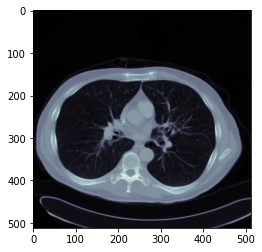

In [22]:
ct = dicom_file.pixel_array # carga los píxeles de la imagen como un array de numpy
plt.figure()
plt.imshow(ct, cmap = "bone") # primero se envían los datos, y en cmap el color

Podemos realizar de nuevo una comprobación rápida y asegurarnos de que la forma de la imagen se corresponde con las filas y columnas que vimos anteriormente en la información de la cabecera (512x512).

In [23]:
print(ct.shape)

(512, 512)


## <font color='#FF3399'> Trabajando con datos 3D </font> <a class="anchor" id="3d_images"></a>
En esta sección echaremos un vistazo a una resonancia magnética (MRI) de cabeza completa, para aprender a manejar datos 3D almacenados como múltiples archivos 2D DICOM.</br>

### Dataset <a class="anchor" id="dataset2"></a>
Los datos están tomados de aquí (https://zenodo.org/record/16956#.YFMM5PtKiV5) y de nuevo almacenados en este directorio.</br>

### Código <a class="anchor" id="codigo2"></a>
#### <font color='#FF6600'> Librerías</font> <a class="anchor" id="librerias2"></a>
De nuevo vamos a importar las librerías necesarias:
* pathlib: se utiliza para manejar de forma sencilla ficheros.
* pydicom: se utiliza para trabajar con ficheros DICOM.
* pyplot: para visualización de las imágenes.
* numpy: para crear los contenedores 3D o voxels.

In [3]:
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt 
import numpy as np

#### <font color='#FF6600'> Cargar imágenes 3D </font> <a class="anchor" id="carga3d"></a>
En el caso de las imágenes en 3D normalmente hay un archivo por cada corte, así que tenemos que leer todos los archivos y añadir los cortes a una lista.</br>
En primer lugar, utilizamos la función ***Path()*** sobre el directorio "SE000001/", que ofrecerá la clase que representa la ruta del sistema de archivos a este directorio, con la semántica apropiada para trabajar con ella en python.

In [5]:
path_to_head_mri = Path("SE000001")

Podemos utilizar la función ***glob()*** para devolver todos los elementos de un directorio que se correspondan con el patrón proporcionado.</br>
Como en este caso, el directorio sólo contiene los ficheros DICOM, podemos devolver todos los ficheros que contiene utilizando el asterisco.</br>
La función _glob()_ devuelve un generador. En Python, un generador es una función que devuelve un iterador que produce una secuencia de valores cuando se itera sobre él. Los generadores son útiles cuando queremos producir una gran secuencia de valores, pero no queremos almacenarlos todos a la vez en memoria.

In [6]:
path_to_head_mri.glob("*")

<generator object Path.glob at 0x7fbad2251d60>

Como devuelve un generador, para poder trabajar con ello lo convertimos en una lista.

In [19]:
all_files = list(path_to_head_mri.glob("*"))
all_files

[PosixPath('SE000001/MR000010'),
 PosixPath('SE000001/MR000009'),
 PosixPath('SE000001/MR000001'),
 PosixPath('SE000001/MR000004'),
 PosixPath('SE000001/MR000003'),
 PosixPath('SE000001/MR000024'),
 PosixPath('SE000001/MR000012'),
 PosixPath('SE000001/MR000008'),
 PosixPath('SE000001/MR000011'),
 PosixPath('SE000001/MR000025'),
 PosixPath('SE000001/MR000015'),
 PosixPath('SE000001/MR000018'),
 PosixPath('SE000001/MR000000'),
 PosixPath('SE000001/MR000017'),
 PosixPath('SE000001/MR000019'),
 PosixPath('SE000001/MR000007'),
 PosixPath('SE000001/MR000023'),
 PosixPath('SE000001/MR000020'),
 PosixPath('SE000001/MR000016'),
 PosixPath('SE000001/MR000014'),
 PosixPath('SE000001/MR000021'),
 PosixPath('SE000001/MR000006'),
 PosixPath('SE000001/MR000013'),
 PosixPath('SE000001/MR000026'),
 PosixPath('SE000001/MR000005'),
 PosixPath('SE000001/MR000002'),
 PosixPath('SE000001/MR000022')]

A continuación leeremos estos archivos utilizando el método ***read_file()*** (al igual que en el primer bloque) y los añadiremos a una lista.

In [12]:
mri_data = []

for path in all_files:
    data = pydicom.read_file(path)
    mri_data.append(data)
    
print('Número de archivos DICOM: ', len(mri_data))

Número de archivos DICOM:  27


#### <font color='#FF6600'> Ordenar cortes 2D </font> <a class="anchor" id="sort2d"></a>
Como puede ver en las rutas impresas de arriba, es posible que los ficheros DICOM no estén ordenados de acuerdo con la posición real de la imagen.</br>
Esto puede verificarse inspeccionando el campo _SliceLocation_ de la cabecera del archivo DICOM.

In [14]:
for slice in mri_data:
    print(slice.SliceLocation) # esta es la ubicación del dentro del sistema de coordenadas del escáner

59.9999962290673
53.9999958207213
5.99999663091323
23.9999946081714
17.9999979772582
143.999998928727
71.9999961590453
47.9999970362677
65.9999961939969
149.999999502083
89.9999955528687
107.999995419197
0.0
101.999994745866
113.999995959439
41.9999963629367
137.999998321624
119.999996566542
95.9999960937442
83.9999967682912
125.999997173645
35.9999959546749
77.9999962275740
155.999992554172
29.9999952815023
11.9999973042441
131.999997780749


Es crucial ordenarlas, ya que de lo contrario su escaneo completo estaría revuelto y sería inútil.</br>
Podemos utilizar el atributo _"SliceLocation"_ pasado a la función ***sorted()*** para identificar la posición de cada corte 2D y así ordenarlos.

In [17]:
# Esto ordenará cada corte acorde a su localización
mri_data_ordered = sorted(mri_data, key=lambda slice:slice.SliceLocation)

A continuación, la explicación de ChatGPT de esta línea de código:</br>

Esta línea de código ordena una lista de datos de imágenes de resonancia magnética (MRI) en orden ascendente según la ubicación de cada "rebanada" de la imagen en el eje Z.</br>

Aquí hay una explicación más detallada:</br>

La función ***sorted()*** toma una lista y devuelve una versión ordenada de la misma. En este caso, la lista original se llama _mri_data_.

* El primer argumento de _sorted()_ es la lista a ordenar, _mri_data_.

* El segundo argumento de _sorted()_ es una función de "clave" que especifica cómo se deben comparar los elementos de la lista. En este caso, la función de clave es ***lambda slice: slice.SliceLocation***. 

***lambda*** es una palabra clave en Python que se utiliza para definir una función anónima, es decir, una función sin nombre que se define en línea. En este caso, la función anónima toma un argumento llamado slice y devuelve el valor de SliceLocation de ese objeto slice.

El resultado final de _sorted()_ se asigna a la variable mri_data_ordered, que es una lista ordenada según la ubicación de cada "rebanada" de la imagen en el eje Z, es decir, la posición vertical en la que se tomó la imagen.

Si imprimimos de nuevo las slices...

In [18]:
for slice in mri_data_ordered:
    print(slice.SliceLocation)

0.0
5.99999663091323
11.9999973042441
17.9999979772582
23.9999946081714
29.9999952815023
35.9999959546749
41.9999963629367
47.9999970362677
53.9999958207213
59.9999962290673
65.9999961939969
71.9999961590453
77.9999962275740
83.9999967682912
89.9999955528687
95.9999960937442
101.999994745866
107.999995419197
113.999995959439
119.999996566542
125.999997173645
131.999997780749
137.999998321624
143.999998928727
149.999999502083
155.999992554172


#### <font color='#FF6600'> Visualizar imágenes 3D </font> <a class="anchor" id="vis3d"></a>
Ahora extraemos los datos reales (pixel_arrays) de los archivos DICOM y los almacenamos en una lista.

In [26]:
full_volume = []
for slice in mri_data_ordered:
    full_volume.append(slice.pixel_array)

In [24]:
# Convertimos el volumen en un array de numpy
full_volume = np.array(full_volume)
print(full_volume.shape)

(27, 256, 256)


En el código que se mostrará a continuación utilizaremos la librería ***Mathplotlib*** para visualizar algunos cortes del volumen 3D ordenado. Para ello se genera una figura que consta de una matriz de 3x3 subplots o gráficas en una cuadrícula, cada una de las cuales muestra una "rebanada" o sección de una imagen de volumen completo. La imagen completa está almacenada en la variable _full_volume_.

Aquí hay una explicación más detallada:

La primera línea de código utiliza la función ***subplots()*** de Matplotlib para crear una figura con 3 filas y 3 columnas de subplots. La figura se asigna a la variable fig y los objetos de los subplots se asignan a la variable axis.

El segundo conjunto de líneas de código usa un bucle for anidado para recorrer cada uno de los 9 subplots.

Para cada subplot, se utiliza la función ***imshow()*** de Matplotlib para mostrar una sección de la imagen completa _(full_volume[slice_counter])_ en el subplot. La opción _cmap="bone"_ se utiliza para aplicar una paleta de colores en escala de grises a la imagen.

El contador _slice_counter_ se actualiza después de cada ciclo del bucle para asegurar que se muestren las secciones de la imagen en orden. Al final del ciclo, el resultado es una figura de 3x3 subplots que muestra las diferentes secciones de la imagen completa.

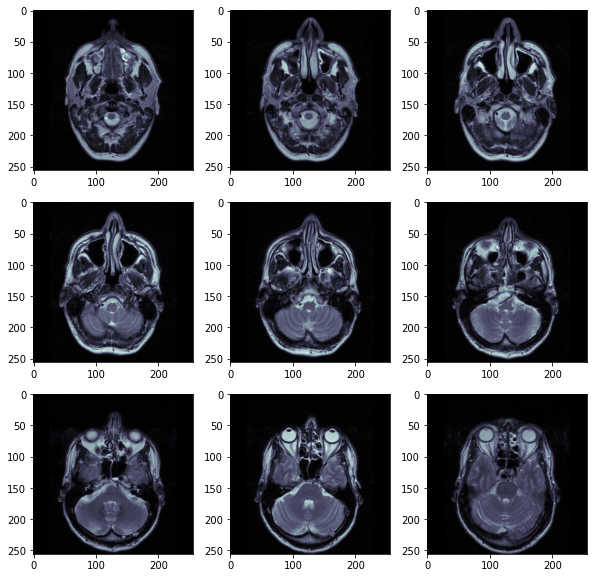

In [35]:
fig, axis = plt.subplots(3, 3, figsize=(10,10))

slice_counter = 0
for i in range(3):
    for j in range (3):
        axis[i][j].imshow(full_volume[slice_counter], cmap ="bone")
        slice_counter+=1

### SimpleITK <a class="anchor" id="simpleitk"></a>

La lectura y ordenado manual de los archivos DICOM puede ser tedioso. SimpleITK proporciona la funcionalidad de detectar y leer todos los archivos DICOM de un directorio sin la necesidad de esta lectura y ordenado manuales. Esta rutina es siempre idéntica:
* (1) Leer todos los ID de los archivos en el directorio 
* (2) Seleccionar los archivos que tengan el ID deseado
* (3) Definir un lector de imágenes y pasarle todos los IDs seleccionados

#### <font color='#FF6600'> Librerías</font>

In [13]:
import SimpleITK as sitk

* (1) Leer todos los ID de los archivos en el directorio 

In [8]:
# Hay que tener en cuenta que SimpleITK es una librería de C++ que no maneja paths, así que se pasa como string
series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(path_to_head_mri))
print(series_ids)

('1.3.46.670589.11.0.0.11.4.2.0.12098.5.4500.2015011413262801702',)


* (2) Seleccionar los archivos que tengan el ID deseado

In [10]:
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(path_to_head_mri), series_ids[0])
series_file_names  # Los ficheros ya están ordenados como se puede ver

('SE000001/MR000000',
 'SE000001/MR000001',
 'SE000001/MR000002',
 'SE000001/MR000003',
 'SE000001/MR000004',
 'SE000001/MR000005',
 'SE000001/MR000006',
 'SE000001/MR000007',
 'SE000001/MR000008',
 'SE000001/MR000009',
 'SE000001/MR000010',
 'SE000001/MR000011',
 'SE000001/MR000012',
 'SE000001/MR000013',
 'SE000001/MR000014',
 'SE000001/MR000015',
 'SE000001/MR000016',
 'SE000001/MR000017',
 'SE000001/MR000018',
 'SE000001/MR000019',
 'SE000001/MR000020',
 'SE000001/MR000021',
 'SE000001/MR000022',
 'SE000001/MR000023',
 'SE000001/MR000024',
 'SE000001/MR000025',
 'SE000001/MR000026')

* (3) Definir un lector de imágenes y pasarle todos los IDs seleccionados

In [11]:
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)
image_data = series_reader.Execute()

In [12]:
print(image_data.GetSize()) # muestra el tamaño del volumen 3D

(256, 256, 27)


#### <font color='#FF6600'> Esto es todo lo necesario para tener los datos en volúmenes 3D</font>
Como puedes ver, el tamaño es (256, 256, 27), mientras que más arriba era (27, 256, 256). Esto solo se debe a una diferencia de orden en las dimensiones de las imágenes.  <br>

El último paso que hay que realizar es laconversión del objeto *sitk* a un array de *numpy*. Esto se puede hacer mediante la función *GetArrayFromImage(image_data)*.

In [15]:
head_mri = sitk.GetArrayFromImage(image_data)
print(type(head_mri))
print(head_mri.shape)

<class 'numpy.ndarray'>
(27, 256, 256)


Para visualizar el código se puede reutilizar el código de los apartados anteriores.

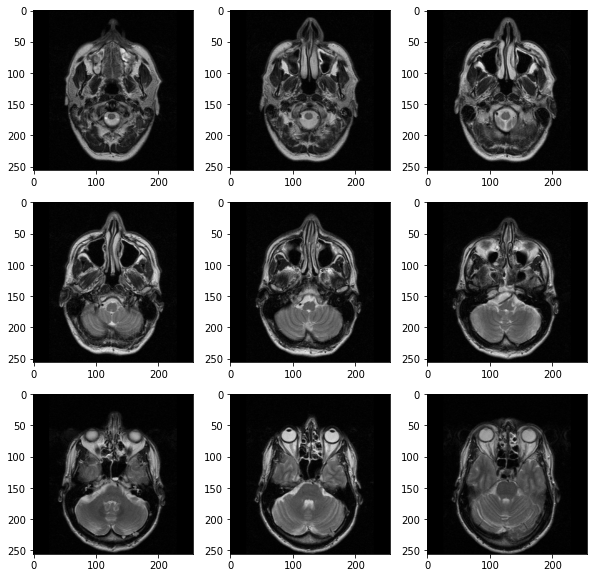

In [16]:
fig, axis = plt.subplots(3, 3, figsize=(10, 10))

slice_counter = 0
for i in range(3):
    for j in range(3):
        axis[i][j].imshow(head_mri[slice_counter], cmap="gray")
        slice_counter+=1